In [3]:
X_test.to_csv('Results/X_test.csv', index=False)

In [5]:
y_test.to_csv('Results/y_test_rf.csv', index=False)

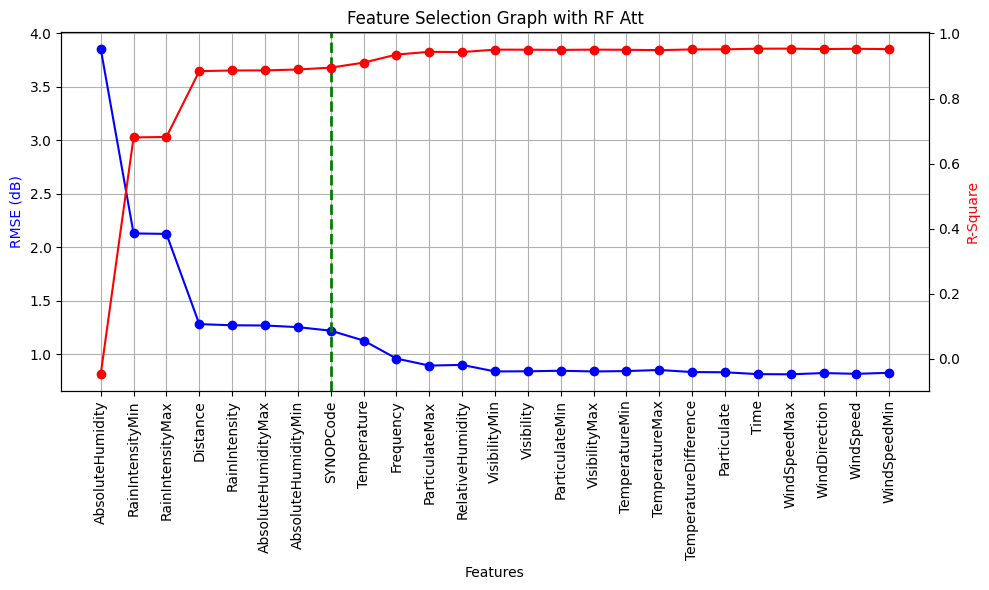

In [2]:
# Plotting the feature selection graph with dots
fig, ax1 = plt.subplots(figsize=(10, 6))

# RMSE curve with dots
ax1.plot(sorted_features_for_graph, rmse_values_for_graph, color='blue', label="RMSE (dB)", marker='o')
ax1.set_xlabel("Features")
ax1.set_ylabel("RMSE (dB)", color="blue")
ax1.tick_params(axis='x', rotation=90)
ax1.grid()

# Add a green vertical line for optimal features
plt.axvline(x=7, color='green', linestyle='--', linewidth=2, label='Optimal Features (8)')

# R^2 curve with dots
ax2 = ax1.twinx()
ax2.plot(sorted_features_for_graph, r2_values_for_graph, color='red', label="R-Square", marker='o')
ax2.set_ylabel("R-Square", color="red")

# Finalize the plot
plt.title("Feature Selection Graph with RF Att")
fig.tight_layout()
plt.show()


In [6]:
print(sorted_features_for_graph)

Index(['AbsoluteHumidity', 'RainIntensityMin', 'Distance', 'RainIntensityMax',
       'RainIntensity', 'SYNOPCode', 'AbsoluteHumidityMin',
       'AbsoluteHumidityMax', 'Temperature', 'Frequency', 'RelativeHumidity',
       'Visibility', 'VisibilityMin', 'VisibilityMax', 'ParticulateMax',
       'ParticulateMin', 'Particulate', 'TemperatureMin',
       'TemperatureDifference', 'TemperatureMax', 'Time', 'WindSpeedMax',
       'WindDirection', 'WindSpeed', 'WindSpeedMin'],
      dtype='object')


# Backward Selection

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Load the dataset
data = pd.read_csv('downsampled_data.csv')

# Prepare the dataset
X = pd.get_dummies(data.drop(columns=['RFL_Att', 'FSO_Att']), drop_first=True)  # Independent variables
y = data['RFL_Att']  # Dependent variable

# Initialize variables for backward elimination
remaining_features = list(X.columns)
rmse_values = []
r2_values = []
oob_scores = []
feature_counts = []
features_removed = []

# Perform backward elimination
while len(remaining_features) > 0:
    # Train the Random Forest model on the remaining features with OOB
    rf_model = RandomForestRegressor(random_state=42, oob_score=True)
    rf_model.fit(X[remaining_features], y)  # No test split; uses OOB
    
    # OOB R² score
    oob_scores.append(rf_model.oob_score_)
    
    # Predictions on the full dataset (or split dataset if needed)
    y_pred = rf_model.predict(X[remaining_features])
    
    # RMSE and R² scores
    rmse_values.append(np.sqrt(mean_squared_error(y, y_pred)))
    r2_values.append(r2_score(y, y_pred))
    
    # Record the number of features
    feature_counts.append(len(remaining_features))
    
    # Find and remove the least important feature
    feature_importances = rf_model.feature_importances_
    least_important_idx = np.argmin(feature_importances)
    least_important_feature = remaining_features[least_important_idx]
    features_removed.append(least_important_feature)
    remaining_features.remove(least_important_feature)

# Create results DataFrame
results = pd.DataFrame({
    'Features_Remaining': feature_counts,
    'RMSE': rmse_values,
    'R²': r2_values,
    'OOB R²': oob_scores,
    'Removed_Feature': features_removed  # Add None for the last row
})

# Print the results
print("\nBackward Elimination Results with RMSE, R², and OOB:")
print(results)



Backward Elimination Results with RMSE, R², and OOB:
    Features_Remaining      RMSE        R²    OOB R²        Removed_Feature
0                   25  0.332605  0.991874  0.940748          WindDirection
1                   24  0.329725  0.992014  0.941820              WindSpeed
2                   23  0.329101  0.992044  0.942151           WindSpeedMax
3                   22  0.326682  0.992161  0.943098           WindSpeedMin
4                   21  0.329555  0.992022  0.942002            Particulate
5                   20  0.328179  0.992089  0.942454                   Time
6                   19  0.337480  0.991634  0.939328         TemperatureMin
7                   18  0.332421  0.991883  0.941086  TemperatureDifference
8                   17  0.342797  0.991368  0.937367          VisibilityMax
9                   16  0.344982  0.991258  0.936562         TemperatureMax
10                  15  0.341822  0.991417  0.937581         ParticulateMin
11                  14  0.342552  

In [ ]:
results_df = results
# Find the number of features with the lowest RMSE
lowest_rmse_index = results_df['RMSE'].idxmin()
lowest_rmse_features = results_df.loc[lowest_rmse_index, 'Features_Remaining']
lowest_rmse_value = results_df.loc[lowest_rmse_index, 'RMSE']

# Find the number of features with the highest R²
highest_r2_index = results_df['R²'].idxmax()
highest_r2_features = results_df.loc[highest_r2_index, 'Features_Remaining']
highest_r2_value = results_df.loc[highest_r2_index, 'R²']

# Output the results
print(f"Lowest RMSE: {lowest_rmse_value:.4f} with {lowest_rmse_features} features remaining.")
print(f"Highest R²: {highest_r2_value:.4f} with {highest_r2_features} features remaining.")

Lowest RMSE: 0.3267 with 22 features remaining.
Highest R²: 0.9922 with 22 features remaining.


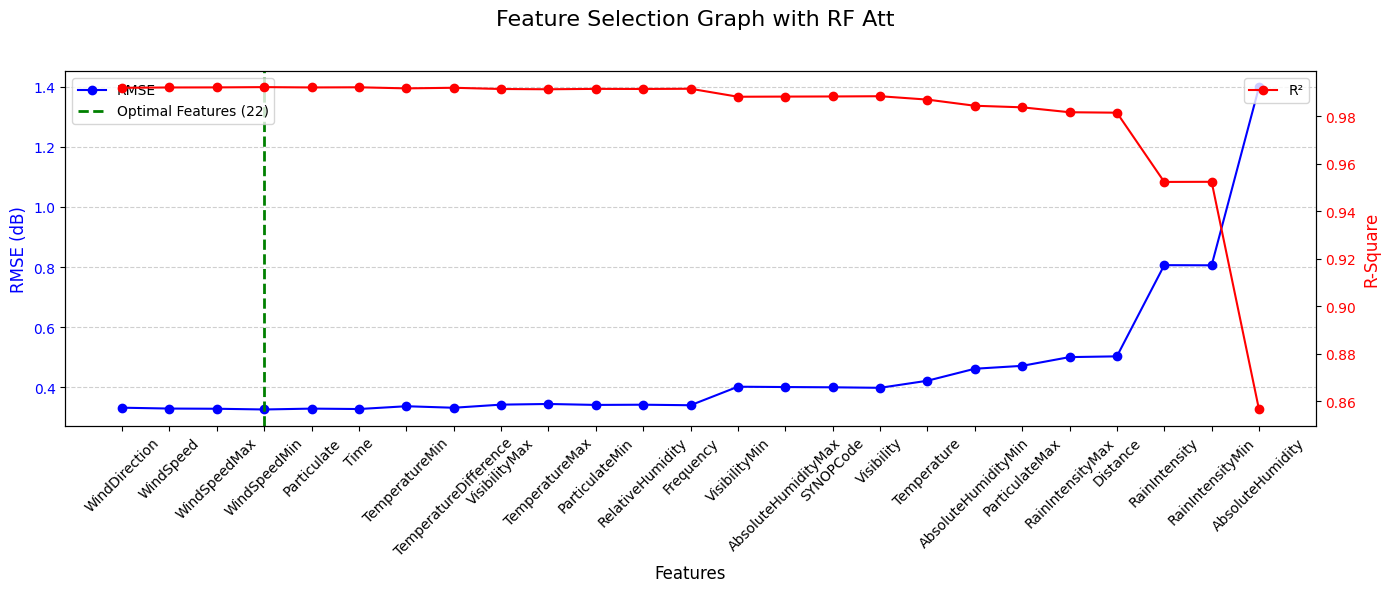

In [ ]:
import matplotlib.pyplot as plt

# Prepare x-axis labels to show all removed features in elimination order
x_labels = results['Removed_Feature'].fillna('Final Features')  # Handle the last row with remaining features
optimal_feature_index = 22  # Specify the optimal number of features

# Create a figure
fig, ax1 = plt.subplots(figsize=(14, 6))

# Plot RMSE with the primary y-axis
ax1.plot(x_labels, results['RMSE'], marker='o', label='RMSE', color='blue')
ax1.set_xlabel('Features', fontsize=12)
ax1.set_ylabel('RMSE (dB)', fontsize=12, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.tick_params(axis='x', rotation=45)  # Rotate x-axis labels for readability
ax1.grid(axis='y', linestyle='--', alpha=0.6)

# Create a secondary y-axis for R²
ax2 = ax1.twinx()
ax2.plot(x_labels, results['R²'], marker='o', label='R²', color='red')
ax2.set_ylabel('R-Square', fontsize=12, color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add a vertical line for the optimal number of features
optimal_feature_name = x_labels.iloc[len(results) - optimal_feature_index]
ax1.axvline(optimal_feature_name, color='green', linestyle='--', label='Optimal Features (22)', linewidth=2)

# Title and legend
fig.suptitle('Feature Selection Graph with RF Att', fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show the plot
plt.show()
